In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_Ks/test_mass/showers_df_evaluation/0_0_None_hdbscan.pt"
path_hgcal = "/eos/user/g/gkrzmanc/eval_plots_EC/Ks_GATr_EP_regression_with_GT_clustering_1_without_normalization/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)


path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_Ks/test_mass/showers_df_evaluation/0_0_None_pandora.pt"
path_hgcal = "/eos/user/g/gkrzmanc/eval_plots_EC/Ks_GATr_EP_regression_with_GT_clustering_1_without_normalization/showers_df_evaluation/0_0_None_pandora.pt"
sd_hgb1, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)


In [33]:
def determibe_decay_type(sd_hgb1, i):
    pid_values = np.abs(sd_hgb1[sd_hgb1.number_batch==i].pid.values)
    if len(pid_values) ==2:
        decay_type = 0
        charged = np.prod(pid_values == [211.,211])
    elif len(pid_values) ==4:
        decay_type = 1
        neutral = np.prod(pid_values == [22., 22., 22., 22.])
    else:
        decay_type = 2
        
    return decay_type
    
p_v_true = sd_hgb1.true_pos.values
E_true = sd_hgb1.true_showers_E.values
p_v_pandora = sd_hgb1.pandora_calibrated_pos.values
E_pandora = sd_hgb1.pandora_calibrated_pfo.values
batch_number = sd_hgb1.number_batch.values
data = []
for batch_id in range(0, int(np.max(batch_number))): 
    mask = batch_number == batch_id
    if np.sum(mask)>0:
        energy_ks = np.nansum(E_true[mask])
        p_v_true_ = [p_v_true[mask][i] for i in range(0,len(p_v_true[mask]))]
        p_v_true_ = np.array(p_v_true_)
        pxj= np.nansum(p_v_true_[:,0])
        pyj= np.nansum(p_v_true_[:,1])
        pzj= np.nansum(p_v_true_[:,2])
        mj = (np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2))) ** (
        1 / 2
        )
        mj = np.sqrt((pxj**2 + pyj**2 + pzj**2))
        energy_ks_p = np.nansum(E_pandora[mask])
        p_v_p = [p_v_pandora[mask][i] for i in range(0,len(p_v_pandora[mask]))]
        p_v_p = np.array(p_v_p)
        pxj_p= np.nansum(p_v_p[:,0])
        pyj_p= np.nansum(p_v_p[:,1])
        pzj_p= np.nansum(p_v_p[:,2])
        mj_p = (np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2))) ** (
        1 / 2
        )
        mj_p = np.sqrt(pxj_p**2+pyj_p**2+pzj_p**2)
        decay_type = determibe_decay_type(sd_hgb1, batch_id)
        if mj>0:
            if mj_p>0:
                data.append([mj, mj_p, mj_p/mj, decay_type, batch_id])
            else:
                data.append([mj, -1, -1, decay_type, batch_id])

df = pd.DataFrame(data, columns=['Mass_true', 'Mass_pandora', 'P_T', 'Type', 'number_batch'])

In [4]:
sd_hgb

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,pred_pos_matched,true_pos
0,0.829008,0.496017,0.496017,0.496017,-211.0,1.645785,0.816338,0.0,0.0,"[0.37723520398139954, 0.9260222315788269, 0.01...","[0.2332606166601181, 0.7830847501754761, 0.011..."
1,3.334543,2.584440,2.584440,2.584441,211.0,1.289170,3.331784,0.0,0.0,"[0.12315111607313156, 0.9813370108604431, -0.1...","[0.49192631244659424, 3.2578439712524414, -0.4..."
0,1.078558,1.304324,1.304324,1.304324,-211.0,0.838370,1.093507,0.0,1.0,"[-0.6871560215950012, 0.7119539380073547, 0.14...","[-0.7470098733901978, 0.7508988380432129, 0.14..."
1,1.139052,1.421865,1.421865,1.421865,211.0,0.793276,1.127931,0.0,1.0,"[-0.45949074625968933, 0.8863198757171631, -0....","[-0.5012989044189453, 1.011171817779541, -0.06..."
0,18.216684,18.979528,18.979525,18.979530,22.0,0.972427,18.456207,0.0,2.0,"[4.24464750289917, -14.170486450195312, 8.0500...","[3.8305678367614746, -15.626825332641602, 8.54..."
...,...,...,...,...,...,...,...,...,...,...,...
1,1.437836,1.053617,1.053617,1.053617,211.0,1.365231,1.438431,69.0,558.0,"[0.6626680493354797, 0.3790678083896637, -0.64...","[0.9539506435394287, 0.5328514575958252, -0.92..."
0,0.245818,0.336376,0.336376,0.336376,22.0,1.512649,0.508819,69.0,559.0,"[-0.15292684733867645, 0.5538443326950073, 0.1...","[-0.0344412736594677, 0.23235958814620972, 0.0..."
1,1.560902,1.623283,1.623283,1.623283,22.0,0.973464,1.580207,69.0,559.0,"[-0.35310229659080505, 1.451424241065979, 0.67...","[-0.526715099811554, 1.3625696897506714, 0.549..."
2,0.213841,0.267544,0.267544,0.267544,22.0,0.000000,0.000000,69.0,559.0,"[-0.16234853863716125, 0.14482295513153076, -0...","[-0.1037447527050972, 0.0830828994512558, 0.16..."


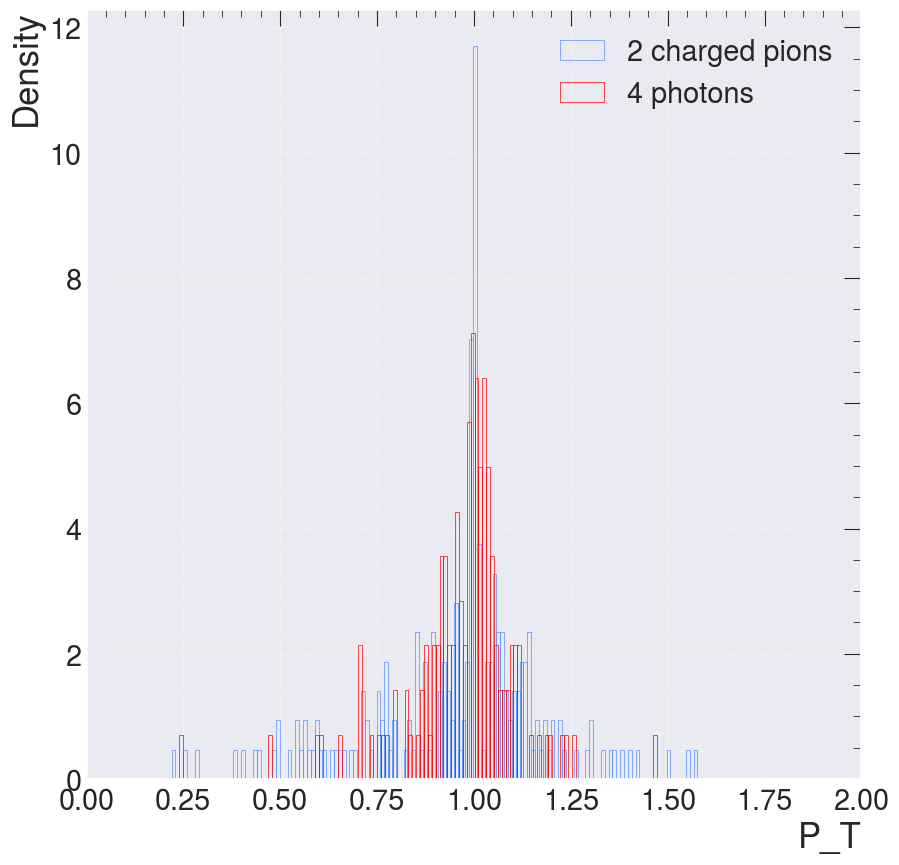

In [34]:
## plot the mass distributions 
import seaborn as sns 
plt.figure()
# 0: 2 pions
# 1: num_batch
sns.histplot(df.P_T[df["Type"]==0], binwidth=0.01, stat="density",  fill=False, label="2 charged pions")
sns.histplot(df.P_T[df["Type"]==1], binwidth=0.01, stat="density", color="r", fill=False, label="4 photons")
# sns.histplot(df.P_T[df["Type"]==2], binwidth = 0.01, stat="density", color="k", fill=False)
plt.legend()
#plt.yscale("log")
plt.xlim([0, 2])
plt.show()


In [62]:
sd_hgb

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,pred_pos_matched,true_pos
0,0.829008,0.496017,0.496017,0.496017,-211.0,1.645785,0.816338,0.0,0.0,"[0.37723520398139954, 0.9260222315788269, 0.01...","[0.2332606166601181, 0.7830847501754761, 0.011..."
1,3.334543,2.584440,2.584440,2.584441,211.0,1.289170,3.331784,0.0,0.0,"[0.12315111607313156, 0.9813370108604431, -0.1...","[0.49192631244659424, 3.2578439712524414, -0.4..."
0,1.078558,1.304324,1.304324,1.304324,-211.0,0.838370,1.093507,0.0,1.0,"[-0.6871560215950012, 0.7119539380073547, 0.14...","[-0.7470098733901978, 0.7508988380432129, 0.14..."
1,1.139052,1.421865,1.421865,1.421865,211.0,0.793276,1.127931,0.0,1.0,"[-0.45949074625968933, 0.8863198757171631, -0....","[-0.5012989044189453, 1.011171817779541, -0.06..."
0,18.216684,18.979528,18.979525,18.979530,22.0,0.972427,18.456207,0.0,2.0,"[4.24464750289917, -14.170486450195312, 8.0500...","[3.8305678367614746, -15.626825332641602, 8.54..."
...,...,...,...,...,...,...,...,...,...,...,...
1,1.437836,1.053617,1.053617,1.053617,211.0,1.365231,1.438431,69.0,558.0,"[0.6626680493354797, 0.3790678083896637, -0.64...","[0.9539506435394287, 0.5328514575958252, -0.92..."
0,0.245818,0.336376,0.336376,0.336376,22.0,1.512649,0.508819,69.0,559.0,"[-0.15292684733867645, 0.5538443326950073, 0.1...","[-0.0344412736594677, 0.23235958814620972, 0.0..."
1,1.560902,1.623283,1.623283,1.623283,22.0,0.973464,1.580207,69.0,559.0,"[-0.35310229659080505, 1.451424241065979, 0.67...","[-0.526715099811554, 1.3625696897506714, 0.549..."
2,0.213841,0.267544,0.267544,0.267544,22.0,0.000000,0.000000,69.0,559.0,"[-0.16234853863716125, 0.14482295513153076, -0...","[-0.1037447527050972, 0.0830828994512558, 0.16..."


In [14]:
sd_hgb.true_showers_E.values

array([0.82900846, 3.3345428 , 1.078558  , ..., 1.5609015 , 0.21384059,
       0.34914732], dtype=float32)

In [13]:
sd_hgb.calibrated_E.values

array([0.81633765, 3.331784  , 1.0935066 , ..., 1.580207  , 0.        ,
       0.40967548], dtype=float32)

In [17]:
sd_hgb

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,pred_pos_matched,true_pos
0,0.829008,0.496017,0.496017,0.496017,-211.0,1.645785,0.816338,0.0,0.0,"[0.37723520398139954, 0.9260222315788269, 0.01...","[0.2332606166601181, 0.7830847501754761, 0.011..."
1,3.334543,2.584440,2.584440,2.584441,211.0,1.289170,3.331784,0.0,0.0,"[0.12315111607313156, 0.9813370108604431, -0.1...","[0.49192631244659424, 3.2578439712524414, -0.4..."
0,1.078558,1.304324,1.304324,1.304324,-211.0,0.838370,1.093507,0.0,1.0,"[-0.6871560215950012, 0.7119539380073547, 0.14...","[-0.7470098733901978, 0.7508988380432129, 0.14..."
1,1.139052,1.421865,1.421865,1.421865,211.0,0.793276,1.127931,0.0,1.0,"[-0.45949074625968933, 0.8863198757171631, -0....","[-0.5012989044189453, 1.011171817779541, -0.06..."
0,18.216684,18.979528,18.979525,18.979530,22.0,0.972427,18.456207,0.0,2.0,"[4.24464750289917, -14.170486450195312, 8.0500...","[3.8305678367614746, -15.626825332641602, 8.54..."
...,...,...,...,...,...,...,...,...,...,...,...
1,1.437836,1.053617,1.053617,1.053617,211.0,1.365231,1.438431,69.0,558.0,"[0.6626680493354797, 0.3790678083896637, -0.64...","[0.9539506435394287, 0.5328514575958252, -0.92..."
0,0.245818,0.336376,0.336376,0.336376,22.0,1.512649,0.508819,69.0,559.0,"[-0.15292684733867645, 0.5538443326950073, 0.1...","[-0.0344412736594677, 0.23235958814620972, 0.0..."
1,1.560902,1.623283,1.623283,1.623283,22.0,0.973464,1.580207,69.0,559.0,"[-0.35310229659080505, 1.451424241065979, 0.67...","[-0.526715099811554, 1.3625696897506714, 0.549..."
2,0.213841,0.267544,0.267544,0.267544,22.0,0.000000,0.000000,69.0,559.0,"[-0.16234853863716125, 0.14482295513153076, -0...","[-0.1037447527050972, 0.0830828994512558, 0.16..."


In [35]:
# Same as prev cell but for charged pions

p_v_true = sd_hgb.true_pos.values
E_true = sd_hgb.true_showers_E.values
p_v_model = sd_hgb.pred_pos_matched.values
E_model = sd_hgb.calibrated_E.values

batch_number = sd_hgb.number_batch.values
data = []

for batch_id in range(0, int(np.max(batch_number))): 
    mask = batch_number == batch_id
    if np.sum(mask) > 0:
        energy_ks = np.nansum(E_true[mask])
        p_v_true_ = [p_v_true[mask][i] for i in range(0,len(p_v_true[mask]))]
        p_v_true_ = np.array(p_v_true_)
        pxj = np.nansum(p_v_true_[:,0])
        pyj = np.nansum(p_v_true_[:,1])
        pzj = np.nansum(p_v_true_[:,2])
        mj = (np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2))) ** (
        1 / 2
        )
        mj = np.sqrt((pxj**2 + pyj**2 + pzj**2))
        energy_ks_p = np.nansum(E_model[mask])
        p_v_p = [p_v_model[mask][i] for i in range(0,len(p_v_model[mask]))]
        p_v_p = np.array(p_v_p)
        pxj_p = np.nansum(p_v_p[:,0])
        pyj_p = np.nansum(p_v_p[:,1])
        pzj_p = np.nansum(p_v_p[:,2])
        mj_p = (np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2))) ** (
        1 / 2
        )
        mj_p = np.sqrt(pxj_p**2+pyj_p**2+pzj_p**2)
        decay_type = determibe_decay_type(sd_hgb, batch_id)
        if mj > 0:
            if mj_p > 0:
                data.append([mj, mj_p, mj_p/mj, decay_type, batch_id])
            else:
                data.append([mj, -1, -1, decay_type, batch_id])

df_ml = pd.DataFrame(data, columns=['Mass_true', 'Mass_ML', 'P_T', 'Type', 'number_batch'])


IndexError: index 2 is out of bounds for axis 0 with size 2

In [31]:
df_ml

,Mass_true,Mass_ML,P_T,Type,number_batch
0,4.133701,1.976479,0.478138,0,0
1,2.161046,1.968980,0.911124,0,1
2,23.868216,23.462990,0.983022,1,2
3,3.791361,4.668224,1.231279,1,3
4,13.879516,13.628468,0.981912,0,4
...,...,...,...,...,...
460,5.606761,1.995703,0.355946,0,553
461,25.589049,27.361106,1.069251,0,555
462,2.734780,1.985356,0.725965,0,556
463,7.969168,7.027841,0.881879,2,557


In [60]:
df_ml

,Mass_true,Mass_ML,P_T,Type,number_batch
0,0.497672,3.646977,7.328079,0,0
1,0.497670,1.028544,2.066720,0,1
2,0.497652,6.526805,13.115210,1,2
3,0.497671,3.090512,6.209948,1,3
4,0.497659,5.930010,11.915799,0,4
...,...,...,...,...,...
460,0.497665,5.261893,10.573158,0,553
461,0.497753,6.556395,13.171998,0,555
462,0.497669,1.404620,2.822396,0,556
463,1.260923,2.685763,2.129998,2,557


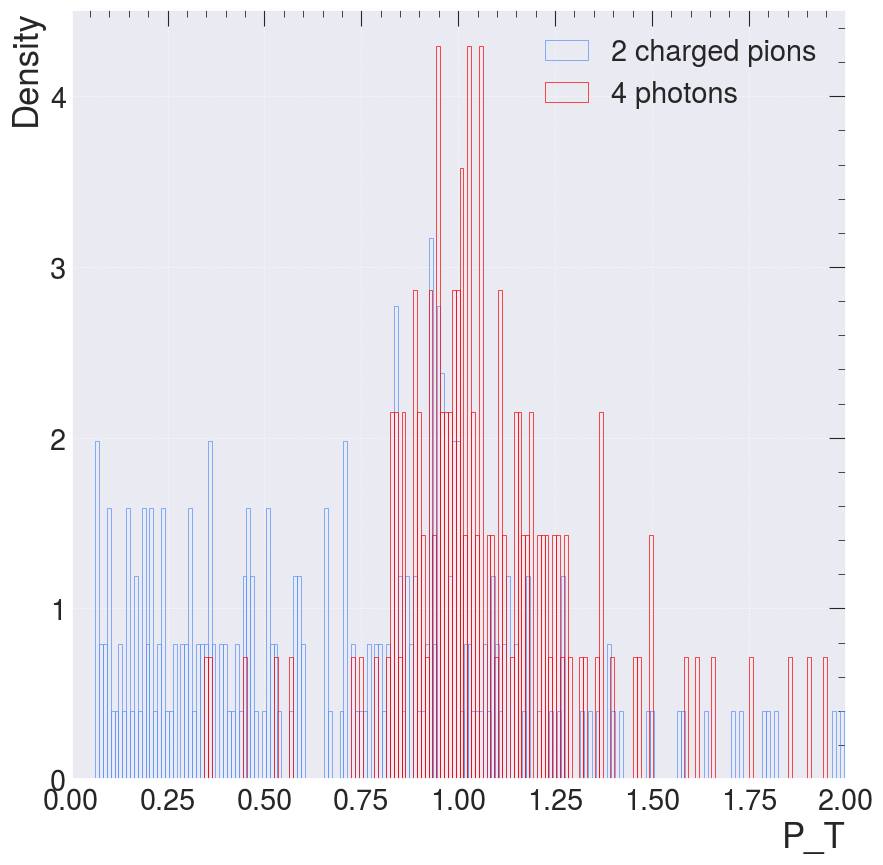

In [32]:
## plot the mass distributions 
import seaborn as sns 
plt.figure()
# 0: 2 pions
# 1: num_batch
sns.histplot(df_ml.P_T[df_ml["Type"]==0], binwidth=0.01, stat="density",  fill=False, label="2 charged pions")
sns.histplot(df_ml.P_T[df_ml["Type"]==1], binwidth=0.01, stat="density", color="r", fill=False, label="4 photons")
# sns.histplot(df.P_T[df["Type"]==2], binwidth = 0.01, stat="density", color="k", fill=False)
plt.legend()
#plt.yscale("log")
plt.xlim([0,2])
plt.show()


In [191]:
example

In [180]:
mask = batch_number == 81
energy_ks = np.nansum(E_true[mask])
p_v_true_ = [p_v_true[mask][i] for i in range(0,len(p_v_true[mask]))]
p_v_true_ = np.array(p_v_true_)
pxj= np.nansum(p_v_true_[:,0])
pyj= np.nansum(p_v_true_[:,1])
pzj= np.nansum(p_v_true_[:,2])
mj = (np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2))) ** (
1 / 2
)
print(mj, energy_ks**2, (pxj**2 + pyj**2 + pzj**2), np.abs(energy_ks**2 - (pxj**2 + pyj**2 + pzj**2)))
energy_ks_p = np.nansum(E_pandora[mask])
p_v_p = [p_v_pandora[mask][i] for i in range(0,len(p_v_pandora[mask]))]
p_v_p = np.array(p_v_p)
pxj_p= np.nansum(p_v_p[:,0])
pyj_p= np.nansum(p_v_p[:,1])
pzj_p= np.nansum(p_v_p[:,2])
mj_p = (np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2))) ** (
1 / 2
)
print(mj_p, energy_ks_p**2, (pxj_p**2 + pyj_p**2 + pzj_p**2), np.abs(energy_ks_p**2 - (pxj_p**2 + pyj_p**2 + pzj_p**2)))

In [164]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

# arrows from 0,0,0 to df.true_pos and the hover text should be the true energy (df.true_showers_E)
fig = go.Figure()
scale = (
    1.0  # size of the direction vector, to make it easier to see it with the hits
)
# list of 20 random colors
# color_list = px.colors.qualitative.Plotly # this is only 10, not enough
color_list = px.colors.qualitative.Light24

def plot_single_arrow(fig, vec, hovertext="", init_pt=[0, 0, 0]):
    # init_pt: initial point of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[init_pt[0], vec[0] + init_pt[0]],
            y=[init_pt[1], init_pt[1] + vec[1]],
            z=[init_pt[2], init_pt[2] + vec[2]],
            mode="lines",
            line=dict(color="black", width=1),
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=[vec[0] + init_pt[0]],
            y=[vec[1] + init_pt[1]],
            z=[vec[2] + init_pt[2]],
            mode="markers",
            marker=dict(size=4, color="black"),
            hovertext=hovertext,
        )
    )

plot_single_arrow(
    fig,
    example.pandora_calibrated_pos.values[0],
)  
plot_single_arrow(
    fig,
    example.true_pos.values[0],
) 
fig.show()

In [36]:
# sd_p = sd_hgb1[sd_hgb1.number_batch==0]
# sd = sd_hgb[sd_hgb.number_batch==0]

In [37]:
# N1 = 0
# N = 20
# sd_p[N1:N].pred_showers_E/sd_p[N1:N].reco_showers_E

In [38]:
# sd[N1:N].pred_showers_E/sd[N1:N].reco_showers_E

In [52]:
sd_hgb1.pandora_calibrated_pos

In [41]:
reco_list = []
reco_list_pandora = []
for i in range(0,int(np.max(sd_hgb.number_batch))):
    mask = sd_hgb.number_batch==i
    event_E_total_reco = np.nansum(sd_hgb.calibrated_E[mask])
    event_ML_total_reco = np.nansum(sd_hgb.true_showers_E[mask])
    mask_p = sd_hgb1.number_batch==i
    event_E_total_reco_p = np.nansum(sd_hgb1.pandora_calibrated_pfo[mask_p])
    event_ML_total_reco_p = np.nansum(sd_hgb1.true_showers_E[mask_p])

    reco_list.append(event_E_total_reco/event_ML_total_reco)
    reco_list_pandora.append( event_E_total_reco_p/event_ML_total_reco_p)

In [47]:
import seaborn as sns
fig = plt.figure()
sns.histplot(reco_list_pandora, binwidth=0.01, stat="percent", color="b", element="step", fill=False)
sns.histplot(reco_list, binwidth=0.01, stat="percent", color="r", element="step", fill=False)
plt.axvline(x=1)
plt.xlim([0,2])

In [8]:
total_showers = len(sd_hgb.true_showers_E) - np.sum(np.isnan(sd_hgb.true_showers_E))
matched_showers = len(matched_hgb)
matched_showers/total_showers
mask = matched_hgb["calibration_factor"]>0
db_test = matched_hgb[mask]
db_test_f = db_test[db_test["pid"]==22]


total_showers1 = len(sd_hgb.true_showers_E) - np.sum(np.isnan(sd_hgb.true_showers_E))
matched_showers1 = len(matched_hgbq1)
matched_showers1/total_showers1
db_test1 = matched_hgbq1
db_test_f1 = db_test1[db_test1["pid"]==22]
print(len(db_test_f),len(db_test_f1))


In [90]:
from src.utils.inference.inference_metrics import get_sigma_gaussian
def calculate_response(matched, pandora, log_scale=False, tracks=False):
    if log_scale:
        bins = np.exp(np.arange(np.log(0.1), np.log(80), 0.3))
    else:
        bins = np.arange(0, 51, 6)
    binning = 1e-4
    if pandora:
        bins_per_binned_E = np.arange(0.5, 1.5, binning)
    else:
        bins_per_binned_E = np.arange(0.5, 1.5, binning)
    mean = []
    variance_om = []
    mean_baseline = []
    variance_om_baseline = []
    mean_true_rec = []
    variance_om_true_rec = []
    energy_resolutions = []
    energy_resolutions_reco = []

   
    binning = 1e-3
    if pandora:
        bins_per_binned_E = np.arange(0, 2, binning)
    else:
        bins_per_binned_E = np.arange(0, 2, binning)
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = matched["true_showers_E"] <= bin_i1
        mask_below = matched["true_showers_E"] > bin_i
        mask_check = matched["pred_showers_E"] > 0
        mask = mask_below * mask_above * mask_check
        true_e = matched.true_showers_E[mask]
        true_rec = matched.reco_showers_E[mask]
        if pandora:
            if tracks:
                pred_e = matched.pandora_calibrated_pfo[mask]
            else:
                pred_e = matched.pandora_calibrated_E[mask]
        else:
            pred_e = matched.calibrated_E[mask]
        pred_e_nocor = matched.pred_showers_E[mask]
        if np.sum(mask) > 0:  # if the bin is not empty
            e_over_true = pred_e / true_e
            e_over_reco = true_rec / true_e
            e_over_reco_ML = pred_e_nocor / true_e
            # mean_predtotrue, var_predtotrue = obtain_MPV_and_68(
            #     e_over_true, bins_per_binned_E
            # )

            mean_predtotrue, var_predtotrue = get_sigma_gaussian(
                e_over_true, bins_per_binned_E
            )

            mean_reco_true, var_reco_true = get_sigma_gaussian(
                e_over_reco, bins_per_binned_E
            )

            mean_reco_ML, var_reco_ML = get_sigma_gaussian(
                e_over_reco_ML, bins_per_binned_E
            )
            # mean_reco_true, var_reco_true = obtain_MPV_and_68(
            #     e_over_reco, bins_per_binned_E
            # )

            # mean_predtotrue = np.mean(e_over_true)
            # var_predtotrue = np.var(e_over_true) / mean_predtotrue
            mean_true_rec.append(mean_reco_ML)
            variance_om_true_rec.append(np.abs(var_reco_ML))
            mean_baseline.append(mean_reco_true)
            variance_om_baseline.append(np.abs(var_reco_true))
            mean.append(mean_predtotrue)
            variance_om.append(np.abs(var_predtotrue))
            energy_resolutions.append((bin_i1 + bin_i) / 2)
            energy_resolutions_reco.append((bin_i1 + bin_i) / 2)

    return (
        mean,
        variance_om,
        mean_true_rec,
        variance_om_true_rec,
        energy_resolutions,
        energy_resolutions_reco,
        mean_baseline,
        variance_om_baseline,
    )


In [91]:
(
    mean1,
    variance_om1,
    mean_true_rec1,
    variance_om_true_rec1,
    energy_resolutions1,
    energy_resolutions_reco1,
    mean_baseline1,
    variance_om_baseline1,
) =calculate_response(db_test_f, False, log_scale=False, tracks=True)

In [82]:
(
    mean_p,
    variance_om_p,
    mean_true_rec_p,
    variance_om_true_rec_p,
    energy_resolutions_p,
    energy_resolutions_reco_p,
    mean_baseline,
    variance_om_baseline,
) = calculate_response(db_test_f1, True, False, tracks=True)
(
    mean,
    variance_om,
    mean_true_rec,
    variance_om_true_rec,
    energy_resolutions,
    energy_resolutions_reco,
    mean_baseline,
    variance_om_baseline,
) = calculate_response(db_test_f, False, False, tracks=True)

In [92]:
plt.figure()
plt.plot(variance_om_p,'x')
plt.plot(variance_om,'x')
plt.plot(variance_om_true_rec1,'o')
plt.yscale("log")

In [114]:
df1 = db_test_f[db_test_f.true_showers_E>2]
df1[0:10]

In [113]:
df2 = db_test_f1[db_test_f1.true_showers_E>2]
df2[0:10]

In [118]:
plt.figure()
sns.histplot(df1.pred_showers_E/df1.true_showers_E, stat = "percent", binwidth = 0.1)
sns.histplot(df2.pred_showers_E/df2.true_showers_E,stat = "percent", binwidth = 0.1)
plt.xlim([0,3])


In [71]:
bins = np.arange(0, 51, 6)
binning = 1e-3
pandora = False
tracks = True
matched = db_test_f
if pandora:
    bins_per_binned_E = np.arange(0, 2, binning)
else:
    bins_per_binned_E = np.arange(0, 2, binning)
i = 0 
bin_i = bins[i]
bin_i1 = bins[i + 1]
mask_above = matched["true_showers_E"] <= bin_i1
mask_below = matched["true_showers_E"] > bin_i
mask_check = matched["pred_showers_E"] > 0
mask = mask_below * mask_above * mask_check
true_e = matched.true_showers_E[mask]
true_rec = matched.reco_showers_E[mask]
if pandora:
    if tracks:
        pred_e = matched.pandora_calibrated_pfo[mask]
    else:
        pred_e = matched.pandora_calibrated_E[mask]
else:
    pred_e = matched.calibrated_E[mask]
pred_e_nocor = matched.pred_showers_E[mask]
if np.sum(mask) > 0:  # if the bin is not empty
    e_over_true = pred_e / true_e
    e_over_reco = true_rec / true_e
    e_over_reco_ML = pred_e_nocor / true_rec

matched = db_test_f1
if pandora:
    bins_per_binned_E = np.arange(0, 2, binning)
else:
    bins_per_binned_E = np.arange(0, 2, binning)
bin_i = bins[i]
bin_i1 = bins[i + 1]
mask_above = matched["true_showers_E"] <= bin_i1
mask_below = matched["true_showers_E"] > bin_i
mask_check = matched["pred_showers_E"] > 0
mask = mask_below * mask_above * mask_check
true_e = matched.true_showers_E[mask]
true_rec = matched.reco_showers_E[mask]
pred_e = matched.pandora_calibrated_pfo[mask]
    
pred_e_nocor = matched.pred_showers_E[mask]
if np.sum(mask) > 0:  # if the bin is not empty
    e_over_true1 = pred_e / true_e
    e_over_reco1 = true_rec / true_e
    e_over_reco_ML1 = pred_e_nocor / true_rec

In [80]:
from scipy.optimize import curve_fit
from scipy import asarray as ar, exp
hist, bin_edges = np.histogram(e_over_true1, bins=bins_per_binned_E, density=True)
# Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X, C, X_mean, sigma):
    return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))

n = len(hist)
x_hist = np.zeros((n), dtype=float)
for ii in range(n):
    x_hist[ii] = (bin_edges[ii + 1] + bin_edges[ii]) / 2

y_hist = hist

mean = sum(x_hist * y_hist) / sum(y_hist)
sigma = sum(y_hist * (x_hist - mean) ** 2) / sum(y_hist)

param_optimised, param_covariance_matrix = curve_fit(
    gaus, x_hist, y_hist, p0=[max(y_hist), mean, sigma], maxfev=10000
)
param_optimised[1], param_optimised[2] / param_optimised[1]

In [ ]:
1.0259126907513694, 0.19836546583500628

In [81]:
import seaborn as sns
plt.figure()
sns.histplot(e_over_true1, stat="percent", binwidth = 0.1)
sns.histplot(e_over_true, stat="percent", binwidth = 0.1)
plt.xlim([0,3])


In [62]:
def get_mask_id(id, pids_pandora):
    mask_id = np.full((len(pids_pandora)), False, dtype=bool)
    for i in id:
        mask_i = pids_pandora == i
        mask_id = mask_id + mask_i
    mask_id = mask_id.astype(bool)
    return mask_id
id = [22]
pids_pandora = np.abs(matched_hgb["pid"].values)
mask_id = get_mask_id(id, pids_pandora)
df_id_pandora = matched_hgb[mask_id]
df_id_pandora

In [75]:
mean = []
variance_om = []
energy_resolutions_reco= []
matched = df_id_pandora
binning = 1e-3
bins = np.arange(0, 51, 6)
bins_per_binned_E = np.arange(0, 2, binning)
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check
    true_e = matched.reco_showers_E[mask]
    true_rec = matched.pred_showers_E[mask]
    if np.sum(mask) > 0:  # if the bin is not empty
        e_over_reco = true_rec / true_e
        _,mean_, resolution = get_sigma_gaussian(e_over_reco)
        mean.append(mean_)
        variance_om.append(np.abs(resolution))
        energy_resolutions_reco.append((bin_i1 + bin_i) / 2)
        if i == 1:
            break



In [71]:
len(e_over_reco)

In [59]:
fig = plt.figure()
x_hist_2=np.linspace(np.min(x_hist),np.max(x_hist),500)
plt.plot(x_hist_2,gaus(x_hist_2,*param_optimised),'r.:',label='Gaussian fit')
plt.legend()

#Normalise the histogram values
weights = np.ones_like(e_over_reco) / len(e_over_reco)
plt.hist(e_over_reco,bins=bins_per_binned_E, density=True)

#setting the label,title and grid of the plot
plt.xlabel("Data: Random variable")
plt.ylabel("Probability")
plt.grid("on")
plt.show()

In [52]:
# sd_true_showers = sd_hgb[~np.isnan(sd_hgb.true_showers_E)]
# x = sd_true_showers.true_showers_E 
# y = sd_true_showers.reco_showers_E
# xedges = np.exp(np.arange(np.log(0.001), np.log(80), 0.5))
# yedges = np.arange(0,100,10)
# H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(131)
# plt.imshow((H+3)/np.sum(H), interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [51]:
A = (H+1)/np.sum(H)
1/(A[-1,:]

In [42]:
plt.plot(xedges,'x')

In [16]:
H.shape

In [16]:
import seaborn as sns
sns.histplot(np.abs(sd_hgb["reco_showers_E"][mask]/sd_hgb["true_showers_E"][mask]), stat="percent")

In [14]:
mask =  ~np.isnan(sd_hgb["reco_showers_E"])
np.sum(~np.isnan(sd_hgb["pred_showers_E"][mask].values)) / len(
            sd_hgb["pred_showers_E"][mask].values
        )

In [18]:
mask2 = np.isnan(sd_hgb["pred_showers_E"][mask].values)
import seaborn
sns.histplot(np.log(sd_hgb[mask][mask2]["true_showers_E"]))

count_events = 0
for i in range(0,len(sd_hgb)):
    ex = sd_hgb.iloc[i]
    if sd_hgb.iloc[0].name == 0:
        count_events = count_events+1
    if sd_hgb.iloc[i].true_showers_E>30 and np.isnan(sd_hgb.iloc[i].pred_showers_E) ==True:
        print(sd_hgb.iloc[i])
        break

In [52]:
27/8071

In [78]:
mask = sd_hgb["true_showers_E"]>26
#mask2 = np.isnan(sd_hgb[mask]["pred_showers_E"])
mask2 = sd_hgb[mask]["true_showers_E"]<28
np.sum(np.isnan(sd_hgb[mask][mask2]["pred_showers_E"]))

In [79]:
len(sd_hgb[mask][mask2])

In [75]:
(len(sd_hgb[mask][mask2])-13)/len(sd_hgb[mask][mask2])

In [50]:
mask = sd_hgb["true_showers_E"]>29
mask2 = np.isnan(sd_hgb[mask]["pred_showers_E"])
sd_hgb[mask][mask2]

In [8]:
8071/1149814*100

In [2]:
from src.utils.inference.pandas_helpers import open_hgcal, open_mlpf_dataframe
neutrals_only = True 
PATH_store = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/test_L/showers_df_evaluation/"
    
path_hgcal = PATH_store + "0_0_None_hdbscan.pt"
path_pandora = PATH_store + "0_0_None_pandora.pt"
# sd_1, matched_1 = open_mlpf_dataframe(path_hgcal, neutrals_only)
# sd_2, matched_2 = open_mlpf_dataframe(path_pandora, neutrals_only)

In [3]:
colors_list = ["#fde0dd", "#c994c7", "#dd1c77"]  # color list poster neurips
data = pd.read_pickle(path_hgcal)
sd = data
mask = (~np.isnan(sd["pred_showers_E"])) * (~np.isnan(sd["true_showers_E"]))
matched_ = sd[mask]
data_pandora = pd.read_pickle(path_pandora)
sd_pandora = data_pandora
mask_pandora = (~np.isnan(sd_pandora["pred_showers_E"])) * (~np.isnan(sd_pandora["true_showers_E"]))
matched_pandora = sd_pandora[mask_pandora]
# from src.utils.inference.per_particle_metrics import get_response_for_id_i
marker_size = 15
log_scale = True
# photons_dic = get_response_for_id_i([22], matched_pandora, matched_)
# electrons_dic = get_response_for_id_i([11], matched_pandora, matched_)

In [4]:
plt.plot(matched_pandora["pred_showers_E"],matched_pandora["true_showers_E"], 'o')

In [129]:
plt.plot(matched_pandora["true_showers_E"],matched_pandora["pandora_calibrated_pfo"], 'o')

In [117]:
sd = sd.reset_index(drop=True)
sd_pandora = sd_pandora.reset_index(drop=True)

In [118]:
number_of_showers = len(sd_pandora["number_batch"].values)
counter_i = 0
counter_total = 0
calibrated_list_pandora = []
reco_list_pandora = []

In [119]:
for i in range(0,500*10):
    sum_by = np.argmax(sd_pandora["number_batch"].values != counter_i)
    temp_sd = sd_pandora[0:sum_by]
    mask = (temp_sd["pred_showers_E"] > 0.6) * (
            np.isnan(temp_sd["true_showers_E"])
        ) + (~np.isnan(temp_sd["true_showers_E"]))
    temp_sd = temp_sd[mask]
    counter_total = counter_total + sum_by
    total_e_event = np.nansum(temp_sd["true_showers_E"].values)
    total_e_reco = np.nansum(temp_sd["reco_showers_E"].values)
    total_e_ML_cali = np.nansum(temp_sd["pandora_calibrated_pfo"].values)
    total_e_reco_ML = np.nansum(temp_sd["pred_showers_E"].values)
    calibrated_list_pandora.append(total_e_ML_cali / total_e_event)

    # print(total_e_ML_cali / total_e_event)
    if total_e_ML_cali / total_e_event>1.4:
        print("here")
        break 
    reco_list_pandora.append(total_e_reco_ML / total_e_reco)

    sd_pandora = sd_pandora.drop(np.arange(0, sum_by))
    counter_i = np.mod(counter_i + 1, 4)
    sd_pandora = sd_pandora.reset_index(drop=True)
    # print("2", number_of_showers, counter_total, number_of_showers - counter_total)


In [120]:
temp_sd

In [101]:
np.isnan(temp_sd["pid"].values[7])

In [64]:
pids = np.abs(sd["pid"].values)
mask_id = pids == 211
df_id = sd[mask_id]
bin_i = 0
bin_i1 = 2
mask_above = df_id.reco_showers_E.values <= bin_i1
mask_below = df_id.reco_showers_E.values > bin_i
mask = mask_below * mask_above
number_of_non_reconstructed_showers = np.sum(
    np.isnan(df_id.pred_showers_E.values)[mask]
)
total_showers = len(df_id.pred_showers_E.values[mask])

(total_showers - number_of_non_reconstructed_showers) / total_showers


In [62]:
df_id

In [5]:
neutrals_dic = get_response_for_id_i([130, 211], matched_pandora, matched_)

In [7]:
data = pd.read_pickle(path_hgcal)
sd = pd.concat([data[data["pid"] == 2112],data[data["pid"] == 130]])
mask = (~np.isnan(sd["pred_showers_E"])) * (~np.isnan(sd["true_showers_E"]))
matched = sd[mask]
data_pandora = pd.read_pickle(path_pandora)
sd_pandora = pd.concat([data_pandora[data_pandora["pid"] == 2112],data_pandora[data_pandora["pid"] == 130]])
mask_pandora = (~np.isnan(sd_pandora["pred_showers_E"])) * (~np.isnan(sd_pandora["true_showers_E"]))
matched_pandora = sd_pandora[mask_pandora]


In [12]:
bin_i1 =20
bin_i = 0
mask_above = matched.true_showers_E.values <= bin_i1
mask_below = matched.true_showers_E.values > bin_i
mask_check = matched["pred_showers_E"] > 0
mask1 = mask_below * mask_above * mask_check
print(np.sum(mask1))
mask_above = matched_pandora.true_showers_E.values <= bin_i1
mask_below = matched_pandora.true_showers_E.values > bin_i
mask_check = matched_pandora["pred_showers_E"] > 0
mask2 = mask_below * mask_above*mask_check
print(np.sum(mask2))

In [10]:
e_over_true = matched[mask1].calibrated_E/matched[mask1].true_showers_E
e_over_true_pandora = matched_pandora[mask2].pandora_calibrated_E/matched_pandora[mask2].true_showers_E

In [145]:
# mask = e_over_true<2
# mask1 = e_over_true_pandora<2
# print(np.std(e_over_true[mask])/np.mean(e_over_true[mask]))
# print(np.std(e_over_true_pandora[mask1])/np.mean(e_over_true_pandora[mask1]))

In [139]:
# from src.utils.inference.inference_metrics import obtain_MPV_and_68
# binning = 1e-3
# bins_per_binned_E = np.arange(0, 2, binning)
# mean_predtotrue, var_predtotrue = obtain_MPV_and_68(
#     e_over_true, bins_per_binned_E
# )
# mean_predtotrue1, var_predtotrue1 = obtain_MPV_and_68(
#     e_over_true_pandora, bins_per_binned_E
# )

In [128]:
# print(mean_predtotrue,var_predtotrue)
# print(mean_predtotrue1,var_predtotrue1)

In [14]:
(1-np.mean(e_over_true))

In [13]:
import seaborn as sns
fig = plt.figure()
ylabel = r"$\frac{E_{reco}}{ E_{true} }$"
plt.xlabel(ylabel, fontsize=40)
plt.ylabel("Percent", fontsize=40)
sns.histplot(e_over_true_pandora, binwidth=0.1, label="Pandora", stat="percent",  color="blue", element="step",linewidth=4,fill=False)
sns.histplot(e_over_true+(1-np.mean(e_over_true)), binwidth=0.1, label="ML", stat="percent", color="red", element="step",linewidth=4, fill=False)
plt.legend(fontsize=40, loc="upper right")
plt.tick_params(axis="both", which="major", labelsize=40)
plt.xlim([0,3])
# plt.yscale("log")

In [26]:
print(np.var(e_over_true)/np.mean(e_over_true))
print(np.var(e_over_true_pandora)/np.mean(e_over_true_pandora))
print(np.var(e_over_true)/np.mean(e_over_true))
print(np.var(e_over_true_pandora)/np.mean(e_over_true_pandora))

In [57]:
from src.utils.inference.inference_metrics import obtain_MPV_and_68
bins_per_binned_E = np.arange(0.9,1.2, 1e-3)
bins_per_binned_E_o = np.arange(0.9,1.2, 1e-3)
mean_predtotrue, var_predtotrue = obtain_MPV_and_68(
    e_over_true, bins_per_binned_E
)

In [58]:
mean_predtotrue_p, var_predtotrue_p = obtain_MPV_and_68(
    e_over_true_pandora, bins_per_binned_E_o
)
var_predtotrue_p

In [59]:
var_predtotrue

In [53]:
hist, bin_edges = np.histogram(e_over_true, bins=bins_per_binned_E, density=True)
    

In [56]:
plt.hist(e_over_true, bins=bins_per_binned_E)

In [51]:
plt.plot(hist)

In [64]:
import seaborn as sns
sns.histplot(e_over_true, binwidth=1e-2, label="ML", stat="percent")
sns.histplot(e_over_true_pandora, binwidth=1e-2, label="Pandora", stat="percent")
plt.legend()

In [41]:
dic = torch.load("/eos/user/m/mgarciam/datasets_mlpf/models_trained/all_energies_10_15/mlpf/mlpf_all_energies_hgcal_v3/showers_df_evaluation/graphs_all/0_2_3.pt", map_location='cpu')

In [42]:
labels_pandora = dic["graph"].ndata["pandora_cluster"].long()

In [43]:
labels_pandora = dic["graph"].ndata["pandora_cluster"].long()
labels_pandora = labels_pandora+1
map_from = list(np.unique(labels_pandora))
cluster_id = map(lambda x: map_from.index(x), labels_pandora)
labels_pandora = torch.Tensor(list(cluster_id)).long()
print(np.unique(labels_pandora))

In [58]:
betas  = torch.sigmoid(dic["graph"].ndata["beta"])
X  = dic["graph"].ndata["coords"]
clustering_mode = "dbscan"
if clustering_mode == "clustering_normal":
    clustering = get_clustering(betas,X)
elif clustering_mode == "dbscan":
    distance_scale = torch.min(torch.abs(torch.min(X,dim=0)[0] - torch.max(X,dim=0)[0]))/35
    print(distance_scale)
    #distance_scale = 0.1
    db = DBSCAN(eps=distance_scale, min_samples=10).fit(X)
    labels = db.labels_ +1
    labels = np.reshape(labels, (-1))
    labels = torch.Tensor(labels).long()

In [59]:
row_ind, col_ind, particle_ids, df = shower_matching(labels)
row_ind_pandora, col_ind_pandora, particle_ids_pandora, df_pandora = shower_matching(labels_pandora)

In [52]:
df_pandora

In [53]:
df

In [117]:
torch.unique(dic["graph"].ndata['particle_number'])

In [48]:
print(scatter_add(torch.ones_like(dic["graph"].ndata['particle_number']),dic["graph"].ndata['particle_number'].to(torch.int64) ))
print(scatter_add(dic["graph"].ndata['e_hits'].view(-1),dic["graph"].ndata['particle_number'].to(torch.int64) ))

In [101]:
mask = dic["graph"].ndata['particle_number']==4
dic["graph"].ndata['e_hits'].view(-1)[mask]

In [7]:
def shower_matching(labels):
    from src.layers.inference_oc import obtain_intersection_matrix, obtain_union_matrix
    particle_ids = torch.unique(dic["graph"].ndata['particle_number'])
    iou_threshold = 0.05
    shower_p_unique = torch.unique(labels)
    if torch.sum(labels == 0) == 0:
            shower_p_unique = torch.cat(
                (
                    shower_p_unique.view(-1),
                    torch.Tensor([0]).to(shower_p_unique.device).view(-1),
                ),
                dim=0,
            )
    e_hits = dic["graph"].ndata['e_hits'].view(-1)
    i_m, i_m_w = obtain_intersection_matrix(shower_p_unique,particle_ids, labels, dic, e_hits)
    u_m = obtain_union_matrix(shower_p_unique,particle_ids, labels, dic)
    iou_matrix = i_m / u_m
    iou_matrix_num = (
            torch.transpose(iou_matrix[1:, :], 1, 0).clone().detach().cpu().numpy()
        )
    iou_matrix_num[iou_matrix_num < iou_threshold] = 0
    row_ind, col_ind = linear_sum_assignment(-iou_matrix_num)
    mask_matching_matrix = iou_matrix_num[row_ind, col_ind] > 0
    row_ind = row_ind[mask_matching_matrix]
    col_ind = col_ind[mask_matching_matrix]
    plot_iou_matrix(iou_matrix,'')
    e_pred_showers = scatter_add(dic["graph"].ndata['e_hits'].view(-1), labels)
    pred_showers = shower_p_unique
    true_showers = particle_ids
    max_num_showers = torch.max(torch.Tensor([len(pred_showers), len(true_showers)]))

    # Add true showers (matched and unmatched)
    energy_t = dic["part_true"][:,3]
    pid = dic["part_true"][:,-2]
    index_matches = col_ind+1
    matched_es = torch.zeros_like(energy_t)*torch.nan
    matched_es[row_ind] = e_pred_showers[index_matches]
    intersection_E = torch.zeros_like(energy_t)*torch.nan
    ie_e = obtain_intersection_values(i_m_w,row_ind, col_ind )
    intersection_E[row_ind] = ie_e
    ## showers that are not in the true showers:
    pred_showers[index_matches] = -1
    mask = pred_showers != -1
    fake_showers_e = e_pred_showers[mask]
    fake_showers_showers_e_truw  = torch.zeros((fake_showers_e.shape[0]))*torch.nan
    energy_t = torch.cat((energy_t, fake_showers_showers_e_truw), dim=0)
    pid_t = torch.cat((pid, fake_showers_showers_e_truw), dim=0)
    e_pred = torch.cat((matched_es,fake_showers_e),dim=0) 
    e_pred_t = torch.cat((intersection_E, torch.zeros_like(fake_showers_e)*torch.nan), dim=0)
    d = {'true_showers_E': energy_t, 'pred_showers_E':e_pred, 'e_pred_and_truth':e_pred_t, "pid":pid_t}
    df = pd.DataFrame(data=d)
    total_showers = len(df["pred_showers_E"].values)
    number_of_non_reconstructed_showers = np.sum(np.isnan(df["pred_showers_E"].values))
    (total_showers-number_of_non_reconstructed_showers)/total_showers
    return row_ind, col_ind, particle_ids, df

In [21]:
particle_label_true = dic["graph"].ndata['particle_number']
model_label = labels

In [24]:
label_matched = torch.ones_like(model_label)*-2
for number_i in range(0, len(row_ind)):
    mask_i = model_label == (col_ind[number_i]+1)
    label_matched[mask_i] = 1*(particle_label_true[mask_i]==particle_ids[row_ind[number_i]]) 

label_matched_pandora = torch.ones_like(model_label)*-2
for number_i in range(0, len(row_ind_pandora)):
    mask_i = labels_pandora == (col_ind_pandora[number_i]+1)
    label_matched_pandora[mask_i] = 1*(particle_label_true[mask_i]==particle_ids[row_ind_pandora[number_i]])

store_image(label=False, cluster=False, true_false=True)
store_image(label=False, cluster=False, pandora=True,  true_false=True)
 

In [66]:
# fig, ax = plt.subplots()
# ax.matshow(intersection_matrix_w, cmap=plt.cm.Blues)
# for i in range(0,intersection_matrix_w.shape[1]):
#     for j in range(0,intersection_matrix_w.shape[0]):
#         c = np.round(intersection_matrix_w[j,i].numpy(),2)
#         ax.text(i, j, str(c), va='center', ha='center')

In [169]:
torch.sum(label_matched_pandora==1)

In [23]:
from src.logger.plotting_tools import shuffle_truth_colors

In [93]:
from src.logger.plotting_tools import shuffle_truth_colors
label_print = dic["graph"].ndata['particle_number'].view(-1).clone()
mask = label_print==4
tidx = label_print.view(-1)
features =  dic["graph"].ndata["e_hits"]
pos_hits =dic["graph"].ndata["pos_hits_xyz"]
data = {
            "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
            "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
            "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
            "tIdx": tidx.view(-1, 1).detach().cpu().numpy(),
            "features": features.view(-1, 1).detach().cpu().numpy(),
        }
hoverdict = {}
# if hoverfeat is not None:
#     for j in range(hoverfeat.shape[1]):
#         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
#     data.update(hoverdict)

# if nidx is not None:
#     data.update({"av_same": av_same})

df = pd.DataFrame(
np.concatenate([data[k] for k in data], axis=1),
columns=[k for k in data],
)
df["orig_tIdx"] = df["tIdx"]
rdst = np.random.RandomState(1234567890)  # all the same
#shuffle_truth_colors(df, "tIdx", rdst)

# hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
# if nidx is not None:
#     hover_data.append("av_same")
fig = px.scatter_3d(
df,
x="X",
y="Y",
z="Z",
color="tIdx",
size="features",
# hover_data=hover_data,
template="plotly_dark",
color_continuous_scale=px.colors.sequential.Rainbow,
)
fig.update_traces(marker=dict(line=dict(width=0)))

In [145]:

store_image(label=False, cluster=False, pandora=True)

In [ ]:
store_image(label=True, cluster=False)

In [49]:
store_image(label=True, cluster=False)
store_image(label = False, cluster=False)
store_image(label=False, cluster=True)
store_image(label = True, cluster=True)
store_image(label = True, true_false=True)

In [10]:
def plot_iou_matrix(iou_matrix, image_path):
    iou_matrix = torch.transpose(iou_matrix[1:, :], 1, 0)
    fig, ax = plt.subplots()
    iou_matrix = iou_matrix.detach().cpu().numpy()
    ax.matshow(iou_matrix, cmap=plt.cm.Blues)
    for i in range(0, iou_matrix.shape[1]):
        for j in range(0, iou_matrix.shape[0]):
            c = np.round(iou_matrix[j, i], 1)
            ax.text(i, j, str(c), va="center", ha="center")

In [11]:
def store_image(label=False, cluster = False, pandora = False, true_false=False):
    if label:
        tidx = np.reshape(labels, (-1,1)) 
    elif pandora:
        if true_false:
            tidx = np.reshape(label_matched_pandora, (-1,1)) 
        else:
            tidx = np.reshape(labels_pandora, (-1,1))
    elif true_false:
        tidx = np.reshape(label_matched, (-1,1)) 
    else:
        tidx = dic["graph"].ndata['particle_number'].view(-1,1)
    features =  torch.log(dic["graph"].ndata["e_hits"])+10
    pos_hits =dic["graph"].ndata["pos_hits_xyz"]
    if cluster:
        pos_hits = X
    data = {
                "X": pos_hits[:, 0].view(-1, 1).detach().cpu().numpy(),
                "Y": pos_hits[:, 1].view(-1, 1).detach().cpu().numpy(),
                "Z": pos_hits[:, 2].view(-1, 1).detach().cpu().numpy(),
                "tIdx": tidx,
                "features": features.view(-1, 1).detach().cpu().numpy(),
            }
    hoverdict = {}
    # if hoverfeat is not None:
    #     for j in range(hoverfeat.shape[1]):
    #         hoverdict["f_" + str(j)] = hoverfeat[:, j : j + 1]
    #     data.update(hoverdict)

    # if nidx is not None:
    #     data.update({"av_same": av_same})

    df = pd.DataFrame(
    np.concatenate([data[k] for k in data], axis=1),
    columns=[k for k in data],
    )
    df["orig_tIdx"] = df["tIdx"]
    rdst = np.random.RandomState(1234567890)  # all the same
    #shuffle_truth_colors(df, "tIdx", rdst)

    # hover_data = ["orig_tIdx", "idx"] + [k for k in hoverdict.keys()]
    # if nidx is not None:
    #     hover_data.append("av_same")
    fig = px.scatter_3d(
    df,
    x="X",
    y="Y",
    z="Z",
    color="tIdx",
    size="features",
    # hover_data=hover_data,
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Rainbow,
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    if pandora and true_false:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label_true_false.html"
    elif true_false:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label__true_false.html"
    elif label and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label.html"
    elif pandora and not cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/pandora_label.html"
    elif label and cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/model_label_cluster.html"
    elif not label and  cluster:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label_cluster.html"
    else:
        path= "/eos/user/m/mgarciam/EVAL_REPOS/mlpf/true_label.html"
    fig.write_html(path)